<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/Scale_Discretize/blob/main/ReScaling_Discretization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

_____

# Rescaling and Discretization

Data comes in different units:

In [1]:
ciaLink="https://github.com/CienciaDeDatosEspacial/Scale_Discretize/raw/refs/heads/main/ciaAll.csv"

In [2]:
import pandas as pd

cia=pd.read_csv(ciaLink)
cia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  133 non-null    object 
 1   region                   133 non-null    object 
 2   InternetccTLD            133 non-null    object 
 3   iso2                     132 non-null    object 
 4   iso3                     133 non-null    object 
 5   fragility                133 non-null    float64
 6   co2                      133 non-null    float64
 7   ForestRev_gdp            133 non-null    float64
 8   inequality               133 non-null    float64
 9   litersAlcohol_percapita  133 non-null    float64
dtypes: float64(5), object(5)
memory usage: 10.5+ KB


Here, you see the different ranges (min-max):

In [3]:
cia.describe()

,fragility,co2,ForestRev_gdp,inequality,litersAlcohol_percapita
count,133.000000,1.330000e+02,133.000000,133.000000,133.000000
mean,65.237594,2.370294e+08,1.374812,36.786466,5.120075
std,24.569307,1.058920e+09,2.362138,7.185220,3.590233
min,16.900000,1.730000e+05,0.000000,24.300000,0.000000
25%,46.000000,4.851000e+06,0.080000,31.700000,2.030000
50%,70.100000,1.675200e+07,0.280000,35.300000,4.400000
75%,83.900000,9.618000e+07,1.560000,40.700000,7.810000
max,113.500000,1.077325e+10,13.270000,59.100000,12.900000


Let me use some columns (the numerical ones):

In [4]:
cia.columns

Index(['Country', 'region', 'InternetccTLD', 'iso2', 'iso3', 'fragility',
       'co2', 'ForestRev_gdp', 'inequality', 'litersAlcohol_percapita'],
      dtype='object')

This is the selection:

<Axes: >

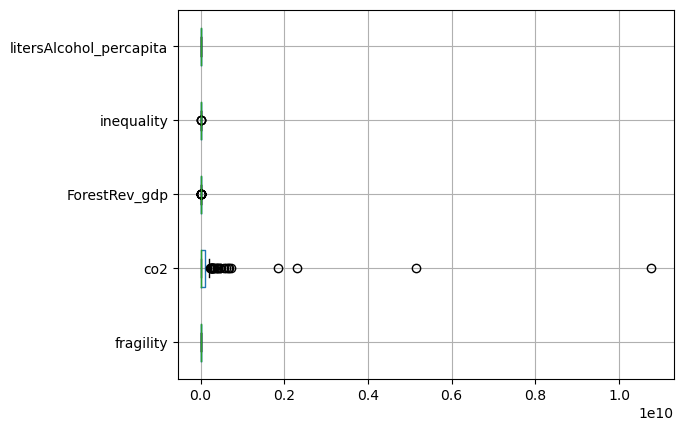

In [5]:
%matplotlib inline

vars=['fragility','co2', 'ForestRev_gdp', 'inequality', 'litersAlcohol_percapita']
cia.loc[:,vars].boxplot(vert=False)

## Re Scaling

The distributions are so dissimilar, that we need to modify (re escale) the values. Let's see three options:

<Axes: >

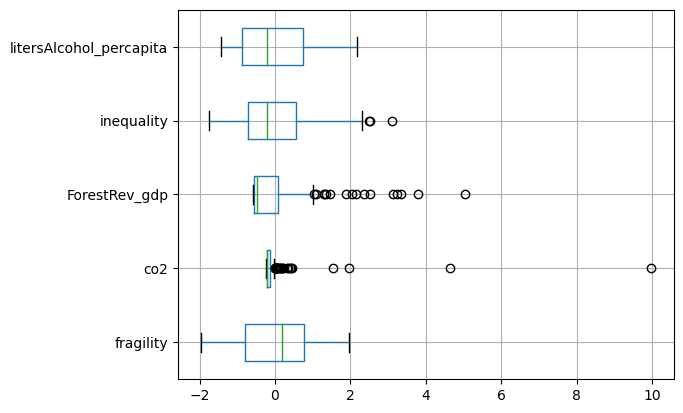

In [6]:
## transforms your data so that it has a mean of 0 and a standard deviation of 1.
## This does alter the shape of distribution

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(cia.loc[:,vars])
pd.DataFrame(normalized_data,columns=vars).boxplot(vert=False)

# it is not robust to atypical outliers

<Axes: >

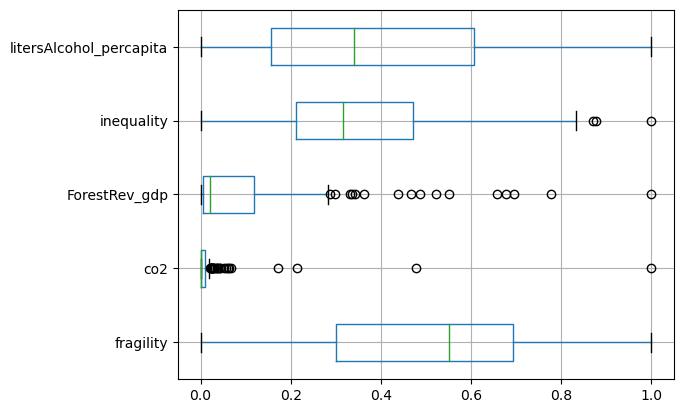

In [7]:
## When you need the scaled features 
## to fall within a specific and interpretable range 
## (e.g., 0 to 1 representing a percentage or a probability).
## This does not alter the shape of distribution

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data=scaler.fit_transform(cia.loc[:,vars])

pd.DataFrame(scaled_data,columns=vars).boxplot(vert=False)

# very sensitive to outliers

<Axes: >

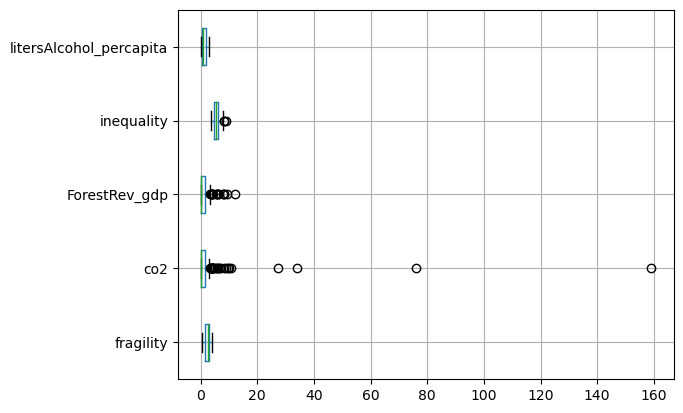

In [8]:
## a common alternative when OUTLIERS are present
## When your dataset contains significant outliers that 
## could skew the mean and standard deviation (used by StandardScaler) 
## or compress the majority of the data into a small range (as with MinMaxScaler),
## RobustScaler provides a more stable scaling.

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(unit_variance=True,with_centering=False)
robScaled_data = scaler.fit_transform(cia.loc[:,vars])

pd.DataFrame(robScaled_data,columns=vars).boxplot(vert=False)


You can take a look at the formulas of the above computations [here](https://docs.google.com/spreadsheets/d/1-CpLjBa7DMtmEUdvIJbX8o7co3rioiTrZNfgbf1osUI/edit?usp=sharing)

The last one, _RobustScaler_, will be kept, which is the the one recommended when outliers are present.

In [9]:
vars_rob_names=[v+'_rob' for v in vars] # new names
cia[vars_rob_names]=robScaled_data

## Discretization

In [10]:
### we may need this installation
# !pip install mapclassify

Here, we will try the different discretization schemes:

In [11]:
import mapclassify
import numpy as np
np.random.seed(12345)

theVar=cia.co2
K=5

# divides your data range into 'K' number of bins of equal width.
ei5 = mapclassify.EqualInterval(theVar, k=K)

# classifies data based on standard deviations from the mean, creating bins around the average value.
msd = mapclassify.StdMean(theVar)

# divides your data into K number of bins, each containing an equal number of observations.
q5=mapclassify.Quantiles(theVar,k=K)

# aims to create classes where the differences between values within a class are relatively small, 
# and the differences between the largest value of one class and the smallest value of the next class are maximized. 
# It looks for natural "jumps" in the sorted data to define the breaks.
mb5 = mapclassify.MaximumBreaks(theVar, k=K)

# with a distribution where many values are small and
# a few are very large (a common scenario where outliers occur)
ht = mapclassify.HeadTailBreaks(theVar)

# finds the optimal classification scheme by minimizing the variance within classes and 
# maximizing the variance between classes. It aims to create the most homogeneous classes possible.
fj5 = mapclassify.FisherJenks(theVar, k=K)

# terative optimization algorithm that aims to find the best class breaks 
# by minimizing the sum of absolute deviations around the class means.
# It starts with an initial classification and iteratively moves data points 
# between adjacent classes to reduce this error until convergence.
jc5 = mapclassify.JenksCaspall(theVar, k=K)

# # intervals based en similarity
mp5 = mapclassify.MaxP(theVar, k=K)


See one of the results:

In [12]:
msd

StdMean

            Interval               Count
----------------------------------------
(          -inf, -1880811312.51] |     0
(-1880811312.51,  -821890964.53] |     0
( -821890964.53,  1295949731.44] |   129
( 1295949731.44,  2354870079.43] |     2
( 2354870079.43, 10773248000.00] |     2

Another one:

In [13]:
ht

HeadTailBreaks

            Interval               Count
----------------------------------------
[     173000.00,   237029383.46] |   109
(  237029383.46,  1178669833.33] |    20
( 1178669833.33,  5020104250.00] |     2
( 5020104250.00,  7958804500.00] |     1
( 7958804500.00, 10773248000.00] |     1

Which one to choose??

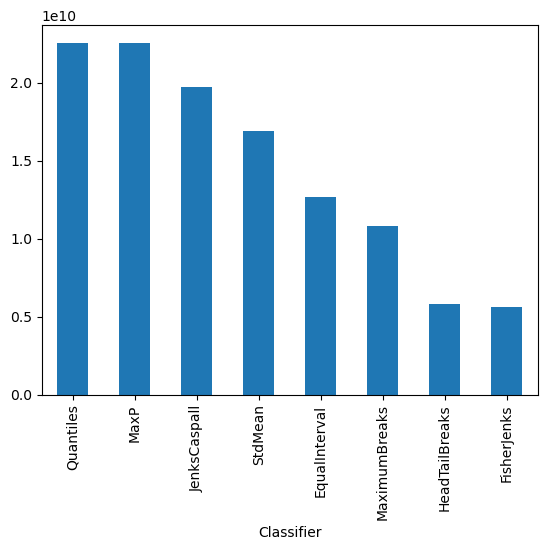

In [14]:
import seaborn
class5 = q5, ei5,msd, ht, mb5, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
adcms.sort_values(by='ADCM', ascending=False).plot(kind='bar', x='Classifier', y='ADCM', legend=False);

As a table:

In [15]:
adcms.sort_values(by='ADCM', ascending=False)

,ADCM,Classifier
0,2.257806e+10,Quantiles
7,2.253071e+10,MaxP
6,1.976802e+10,JenksCaspall
2,1.691521e+10,StdMean
1,1.265417e+10,EqualInterval
4,1.081965e+10,MaximumBreaks
3,5.808183e+09,HeadTailBreaks
5,5.602492e+09,FisherJenks


We will keep the one with the smallest ADCM value:

In [16]:
fj5

FisherJenks

            Interval               Count
----------------------------------------
[     173000.00,   193869000.00] |   107
(  193869000.00,   726881000.00] |    22
(  726881000.00,  2314738000.00] |     2
( 2314738000.00,  5144361000.00] |     1
( 5144361000.00, 10773248000.00] |     1

The group each country will belong:

In [17]:
fj5.yb

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 3, 0, 0, 1, 0, 0,
       0])

In [18]:
#so,
cia['co2_fj5']=fj5.yb

# we have:
cia.loc[:,cia.columns.str.contains('co2|Coun')]

,Country,co2,co2_rob,co2_fj5
0,ALBANIA,3794000.0,0.056039,0
1,ANGOLA,19362000.0,0.285987,0
2,ARGENTINA,193205000.0,2.853744,0
3,ARMENIA,6354000.0,0.093852,0
4,AUSTRALIA,417870000.0,6.172169,1
...,...,...,...,...
128,UZBEKISTAN,102965000.0,1.520850,0
129,VIET NAM,249929000.0,3.691589,1
130,YEMEN,10158000.0,0.150039,0
131,ZAMBIA,6798000.0,0.100410,0
